## Энергетический оракул
Ноутбук команды #12

Работа выполнена на основе модели LightGBM


### 1. Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import re

from tqdm import tqdm

random_state = 12345
NUM_ITERATIONS = 5000

#### 1.1 Функции для расшифровки прогноза погоды в колонке 'weather_pred'

In [2]:
# Расшифровка прогноза в колонке 'weather_pred'

# функция формирует колонки 'cloudy', 'rainy', 'windy', 'clear', 'rain_probability', 'has_rain_probability'
# в колонках число, которое 0 при отсутсвии упоминания явления в weather_pred или степень упоминания
# функция дает в колонках номер первого списка, элемент которого есть в строке плюс 1
# списки cloudy_list, rainy_list, windy_list, clear_list можно модифицировать
# соответственно, можно экспериментировать с расположением значений в списках
# например, сейчас 'дождь', 'снег', 'д+сн' - первая степень  дождя, а 'гроз', 'ливень' - вторая
# а можно сделать снег второй, а грозу с ливнем убрать в третью
# также сделал отдельный список для "ясности", чтобы выделить 'ясно' и 'солнечно'

def in_what_list(weather, big_list):
    for list_number, small_list in enumerate(big_list):
        if any(word in weather for word in small_list):
            return list_number+1
    return 0

def weather_split2(row):
    weather = row['weather_pred']
    cloudy_list = [['проясн', 'пер.об.', 'п/об'], ['пасм', 'обл']]
    rainy_list = [['дождь', 'снег', 'д+сн'], ['гроз', 'ливень']]
    windy_list = [['вет'],['штор']]
    clear_list = [['проясн'], ['ясно'], ['солнеч']]
    numbers = re.findall(r'\d+', weather)
    cloudy = in_what_list(weather, cloudy_list)
    rainy = in_what_list(weather, rainy_list)
    windy = in_what_list(weather, windy_list)
    clear = in_what_list(weather, clear_list)
    rain_probability = 0 if len(numbers)==0 else int(numbers[0])
    has_rain_probability = int(len(numbers)==0)
    return cloudy, rainy, windy, clear, rain_probability, has_rain_probability

def fill_weather_columns(df):
    df['weather_pred'] = df['weather_pred'].fillna('')
    df['cloudy'], df['rainy'], df['windy'], df['clear'], df['rain_probability'], df['has_rain_probability'] = \
                zip(*df.apply(weather_split2, axis=1))
    return df

#### 1.2 Функции для загрузки данных о ВВП 
данные загружаются из файла 'data/VVP.csv'

Некоторые научные работы указывают на прямую связь величины потребления электричества и показателя ВВП, который отражает ситуацию в экономике. Данные по экономике публикуются различными министерствами с разной периодичностью. Для использования в работе были взяты фактические данные по ВВП с сайта investing, который агрегирует публикации Минэкономразвития. Данные за месяц побликуются с месячной задержкой, поэтому модель использует для прогнозирования данные за прошлые месяцы, которые известны.   
  
Ссылка на данные: https://ru.investing.com/economic-calendar/russian-monthly-gdp-407


In [3]:
# Функция добавляет данные о ВВП из файла 'data/VVP.csv' в датасет

def add_vvp2(data, file_source = 'data/VVP.csv'):
    """
    сырой датафрем подаем на вход
    """
    # обработаем файл с динамикой ВВП
    vvp = pd.read_csv(file_source)
    # преобразуем дату файла-источника в формат datetime64 и дропнем один столбик
    vvp['date'] = pd.to_datetime(vvp['date'], format ='%Y-%m-%d %H:%M:%S')
    vvp.drop('for_month',axis=1,inplace=True) 
    
    # обработаем основной фрейм - создадим столбец для соединения, который потом удалим
    data['date_temp'] = pd.to_datetime(data['date'], format = '%Y-%m-%d' )
    data['date_temp'] = data['date_temp'] + pd.to_timedelta(data['time'] , 'H')
    
    # соединяем основной фрейм и ВВП по дате объявления показтеля ВВП
    for idx in reversed(vvp.index):
        data.loc[data['date_temp']>=vvp.date[idx],'VVP'] = vvp.VVP_perc[idx]
        
    data.drop('date_temp',axis=1,inplace=True)   

    return data

#### 1.3 Функции для загрузки архива данных о фактической погоде
данные загружаются из файла 'data/preprocessing_loaded_table.csv'

Изначально данные для формирования таблицы "preprocessing_loaded_table" были взяты из с сайта [https://rp5.ru](https://rp5.ru/Архив_погоды_в_Храброво,_им._императрицы_Елизаветы_Петровны_(аэропорт),_METAR), где хранятся архивы погоды в аэрапорту Калининграда, за период с 31.12.2018 по 30.09.2023

Описание данных в таблице:
- Местное время в Храброво / им. императрицы Елизаветы Петровны (аэропорт) - Дата / Местное время
- T -  Темпиратура воздуха
- Po - Давление на уровне станции
- P - Давление приведённое к уровню моря
- U - Относительная влажность
- DD - Направление ветра
- Ff - Скорость ветра
- ff10 - Максимальное значение порыва ветра
- WW - Особое явление текущей погоды (осадки)
- W'W' - Явление недавней погоды, имеющее оперативное значение
- с - Общая облачность
- VV - Горизонтальная дальность видимости
- Td - Темпиратура точки росы

Данные, которые были взяты из данной таблицы и загружаются из 'data/preprocessing_loaded_table.csv':
- P - не подверглось изменению
- U - не подверглось изменению
- Td - не подверглась изменению

 WW - разделили на 4 категории:
- Нет осадков (где были пропуски)
- слабый дождь
- сильный дождь
- снег

DD - создали 4 столбца, соответствующих сторонам горизонта, которые принимали значения 0; 0.5 и 1 в зависимости от силы ветра в конкретном направлении
- N - north
- S - south
- W - west
- E - east

В дальнейшем эти данные использовались с лагом в сутки: в поля на завтрашний день записывались данные сегодняшнего.

In [4]:
# Функции для работы с данными о фактической погоде из 'data/preprocessing_loaded_table.csv'

# Кодировка информации об осадках из колонки WW
def true_weather_WW_replace(ww):
    if ww=='нет осадков':
        return 0
    elif ww=='слабый дождь':
        return 1
    elif (ww=='сильный дождь') or (ww=='снег'):
        return 2
    else:
        return 3

# Вычисление Timestamp из даты и времени
def row_plus_hours_to_index(row):
    return row['date'] + pd.to_timedelta(row['time'] , 'H')

# Функция для сдвига на сутки (в скачанном датасете разбивка по 30 мин, поэтому timeshift=48)
def shift_features_fact(df, timeshift=48):
    list_fact_columns=list(df.columns)
    list_fact_columns.remove('date_tw')
    new_df = df.copy()
    for column in list_fact_columns:
        new_df[column] = new_df[column].shift(timeshift)

    return new_df

In [5]:
# Функция для вычисления метрики mae по дням из почасовых массивов данных

def mae_day(y_true, y_pred):
    y_true_copy = pd.DataFrame(y_true).reset_index(drop=True)
    y_true_copy['day'] = y_true_copy.index // 24
    y_true_grouped = y_true_copy.groupby(by='day').sum()   
    y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
    y_pred_copy['day'] = y_pred_copy.index // 24
    y_pred_grouped = y_pred_copy.groupby(by='day').sum()
    
    return mean_absolute_error(y_true_grouped, y_pred_grouped)
# Функция для вычисления метрик по дням из почасовых массивов данных

def metrics_day(y_true, y_pred):
    y_true_copy = pd.DataFrame(y_true).reset_index(drop=True)
    y_true_copy['day'] = y_true_copy.index // 24
    y_true_grouped = y_true_copy.groupby(by='day').sum()   
    y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
    y_pred_copy['day'] = y_pred_copy.index // 24
    y_pred_grouped = y_pred_copy.groupby(by='day').sum()
    
    mae = mean_absolute_error(y_true_grouped, y_pred_grouped)
    mape = mean_absolute_percentage_error(y_true_grouped, y_pred_grouped)
    r2 = r2_score(y_true_grouped, y_pred_grouped)
    return mae, mape, r2

#### 1.5 Чтение файлов с данными
Данные объединяются в один датасет

In [6]:
# читаем исходные датасеты и складываем в один
train_ds = pd.read_csv('data/train_dataset.csv')
test_ds = pd.read_csv('data/test_dataset.csv')
train_ds = pd.concat([train_ds, test_ds])

# запоминаем дату начала тестовых данных, потом также поступим и с закрытым датасетом
open_test_begin = pd.to_datetime(test_ds['date']).min()
open_test_end = pd.to_datetime(test_ds['date']).max() + pd.to_timedelta(1,'d')
print('начало открытого теста:', open_test_begin, '    конец открытого теста:', open_test_end)

начало открытого теста: 2023-04-01 00:00:00     конец открытого теста: 2023-08-01 00:00:00


#### 1.6 Формирование колонок с производными от даты

In [7]:
# преобразуем дату и делаем из нее колонки
train_ds['date'] = pd.to_datetime(train_ds['date'])
train_ds['year'] = train_ds['date'].dt.year
train_ds['month'] = train_ds['date'].dt.month
train_ds['day_of_week'] = train_ds['date'].dt.dayofweek
train_ds['day'] = train_ds['date'].dt.day
train_ds['day_of_year'] = train_ds['date'].dt.dayofyear

#### 1.7 Подгрузка данных о праздниках

In [8]:
# Добавление данных о праздниках из файла 'data/holidays.csv'

df_holidays = pd.read_csv('data/holidays.csv')
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

# Assuming df_holidays and train_ds are your dataframes
train_ds = pd.merge(train_ds, df_holidays, on='date', how='left')

# Fill NaN values with 0
train_ds['holidays'].fillna(0, inplace=True)
train_ds['preholidays'].fillna(0, inplace=True)

# Convert to int
train_ds['holidays'] = train_ds['holidays'].astype(int)
train_ds['preholidays'] = train_ds['preholidays'].astype(int)

#### 1.8 Формирование колонок со значением целевого признака в предыдущие дни

In [9]:
# Добавление колонок с временными лагами

# создаем столбец 'temp_last_day'
train_ds['temp_last_day'] = train_ds['temp'].shift(24)

# заполняем пропущенные значения в 'temp_last_day'
train_ds['temp_last_day'].fillna(method='bfill', inplace=True)

# создаем столбцы с временными лагами для 'target'
lags = [24, 48, 72, 7*24, 14*24]
for lag in lags:
    train_ds[f'target_lag_{lag}'] = train_ds['target'].shift(lag)

# заполняем пропущенные значения в столбцах с лагами
for lag in lags:
    train_ds[f'target_lag_{lag}'].fillna(0, inplace=True)

#### 1.9 Формирование колонок с ВВП и данными о погоде посредством ранее описанных функций

In [10]:
# применяем функцию добавления ВВП
train_ds = add_vvp2(train_ds)

# Расшифровка прогноза в колонке 'weather_pred'
train_ds = fill_weather_columns(train_ds)


# Читаем файл с архивом фактической погоды
df_true_weather = pd.read_csv('data/preprocessing_loaded_table.csv')
display(df_true_weather)

# Форматируем колонки
df_true_weather['WW'] = df_true_weather['WW'].apply(true_weather_WW_replace)
df_true_weather['date'] = pd.to_datetime(df_true_weather['date'])
df_true_weather = df_true_weather.rename(columns={'date':'date_tw'})
# Применяем сдвиг на сутки, чтобы не заглядывать в будущее
df_true_weather = shift_features_fact(df_true_weather)
# Добавляем в датасет
train_ds['date_hours'] = train_ds.apply(row_plus_hours_to_index, axis=1)
train_ds = train_ds.merge(df_true_weather, left_on='date_hours', right_on='date_tw')
train_ds = train_ds.drop(['date_hours', 'date_tw'], axis=1)

,date,P,U,WW,Td,N,S,W,E
0,2018-12-31 00:00:00,763.5,100.0,слабый дождь,2.0,1.0,0.0,0.0,0.0
1,2018-12-31 00:30:00,764.3,93.0,слабый дождь,1.0,1.0,0.0,0.0,0.5
2,2018-12-31 01:00:00,764.3,93.0,слабый дождь,1.0,1.0,0.0,0.0,0.0
3,2018-12-31 01:30:00,765.0,93.0,слабый дождь,2.0,1.0,0.0,0.0,0.0
4,2018-12-31 02:00:00,765.0,93.0,нет осадков,2.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
82146,2023-09-30 21:30:00,763.5,82.0,нет осадков,12.0,0.0,0.0,1.0,0.0
82147,2023-09-30 22:00:00,763.5,82.0,нет осадков,12.0,0.5,0.0,1.0,0.0
82148,2023-09-30 22:30:00,763.5,77.0,сильный дождь,11.0,0.0,0.0,1.0,0.0
82149,2023-09-30 23:00:00,763.5,94.0,сильный дождь,13.0,0.5,0.0,1.0,0.0


#### 1.10 Демонстрация сформированного датасета

In [11]:
# Итоговый набор колонок
train_ds.columns

Index(['date', 'time', 'target', 'temp', 'temp_pred', 'weather_pred',
       'weather_fact', 'year', 'month', 'day_of_week', 'day', 'day_of_year',
       'holidays', 'preholidays', 'temp_last_day', 'target_lag_24',
       'target_lag_48', 'target_lag_72', 'target_lag_168', 'target_lag_336',
       'VVP', 'cloudy', 'rainy', 'windy', 'clear', 'rain_probability',
       'has_rain_probability', 'P', 'U', 'WW', 'Td', 'N', 'S', 'W', 'E'],
      dtype='object')

In [12]:
train_ds.head()

,date,time,target,temp,temp_pred,weather_pred,weather_fact,year,month,day_of_week,...,rain_probability,has_rain_probability,P,U,WW,Td,N,S,W,E
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,1,763.5,100.0,1.0,2.0,1.0,0.0,0.0,0.0
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,1,764.3,93.0,1.0,1.0,1.0,0.0,0.0,0.0
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер,2019,1,1,...,0,1,765.0,93.0,0.0,2.0,1.0,0.0,0.0,0.0
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,...,0,1,765.8,87.0,0.0,1.0,1.0,0.0,0.0,0.0
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,...,0,1,766.6,87.0,0.0,1.0,1.0,0.0,0.0,0.0


#### 1.11 Исключение лишних колонок

In [13]:
# Отбираем признаки. Все лишние колонки здесь отбрасываем, кроме 'date', которую уберем позже 

feature_cols = list(train_ds.columns)

# выбрасываем взгляд в прошлое и расшифрованную погоду
drop_list = ['target', 'day_of_year', 'weather_pred', 'weather_fact', 'temp']

# выбрасываем признаки, найденные процедурно в процессе оптимизации
# КОМАНДЕ: здесь можно добавлять признаки на выброс с целью оптимизации
drop_list = drop_list + ['target_lag_48', 'target_lag_168'] #, 'temp_pred'] #, 'target_lag_336'] 

for name in drop_list:
    feature_cols.remove(name)

# Итоговый список признаков
feature_cols

['date',
 'time',
 'temp_pred',
 'year',
 'month',
 'day_of_week',
 'day',
 'holidays',
 'preholidays',
 'temp_last_day',
 'target_lag_24',
 'target_lag_72',
 'target_lag_336',
 'VVP',
 'cloudy',
 'rainy',
 'windy',
 'clear',
 'rain_probability',
 'has_rain_probability',
 'P',
 'U',
 'WW',
 'Td',
 'N',
 'S',
 'W',
 'E']

#### 1.12 Выделение наборов данных для обучения, валидации и тестирования

Выделялось два набора данных для обучения и валидации:
1. Обучение на данных с 2019 по 2021 с валидацией на 2022
2. Обучение на данных с 2019 по 2022 с валидацией на первом квартале 2023

Первый набор позволяет оценить влияние сезонности на обучение и предсказания, второй позволяет обучить модель на большем объеме данных и на более актуальных данных.

In [14]:
# Формируем набор датасетов для обучения и проверки

features = train_ds[feature_cols]
target = train_ds['target']

# Функция для выделения временных интервалов из таблиц признаков и целей
# на этом этапе отбрасываем колонку 'date'
def features_interval(features, target, date1, date2):
    features_interval = features[ (features['date']>=date1) & (features['date']<date2) ]
    target_interval = target[features_interval.index]
    features_interval = features_interval.drop('date', axis=1)
    return features_interval, target_interval

# для первичного подбора гиперпараметров будем обучать на 19-21 годах, валидировать по 2022
features_train, target_train = features_interval(features, target, '2019-01-01', '2022-01-01')
features_valid, target_valid = features_interval(features, target, '2022-01-01', '2023-01-01')

# отбор признаков будем производить, обучая на 19-22 и проверяя по первому кварталу 2023
# с дополнительным контролем на вариантах из первичного обучения
features_2022, target_2022 = features_interval(features, target, '2019-01-01', '2023-01-01')
features_2023, target_2023 = features_interval(features, target, '2023-01-01', open_test_begin)

# для проверки на тестовой выборке будем учиться на всем тренировочном датасете
features_all_train, target_all_train = features_interval(features, target, '2019-01-01', open_test_begin)
features_open_test, target_open_test = features_interval(features, target, open_test_begin, open_test_end)

# формируем наборы данных по кварталам 2022 года, чтобы посмотреть по ним метрику отдельно
dates = ['2022-01-01', '2022-04-01', '2022-07-01', '2022-10-01', '2023-01-01']
quarters = []
for i in range(4):
    f, t = features_interval(features, target, dates[i], dates[i+1])
    quarters.append({'features':f, 'target':t})

### 2. Обучение моделей

В настоящей работе обучается модель LightGBM

#### 2.1 Гиперпараметры
Были подобраны следующие значения гиперпараметров:

In [15]:
params = {'num_leaves':15, 'learning_rate':0.02, 'feature_fraction':1, 'num_iterations':NUM_ITERATIONS, 'random_state':random_state, 'objective':'regression_l1', 'n_jobs':-1}

#### 2.2 Обучение на данных за 2019-2021 годы и предсказание на 2022:

In [16]:
# Демонстрация предсказания с подобранными гиперпараметрами
# Тренируем на 19-21 годах, предсказываем за 2022

lgbm_model = lgb.LGBMRegressor(**params)
lgbm_model.fit(features_train, target_train)

y_pred = lgbm_model.predict(features_valid)
print(f'mae for days - {mae_day(target_valid, y_pred)}')
print(f'mae for hours - {mean_absolute_error(target_valid, y_pred)}')

/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1511
[LightGBM] [Info] Number of data points in the train set: 26217, number of used features: 27
[LightGBM] [Info] Start training from score 464.105011


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
mae for days - 142.02972691605672
mae for hours - 8.135114525306646


<Axes: xlabel='date'>

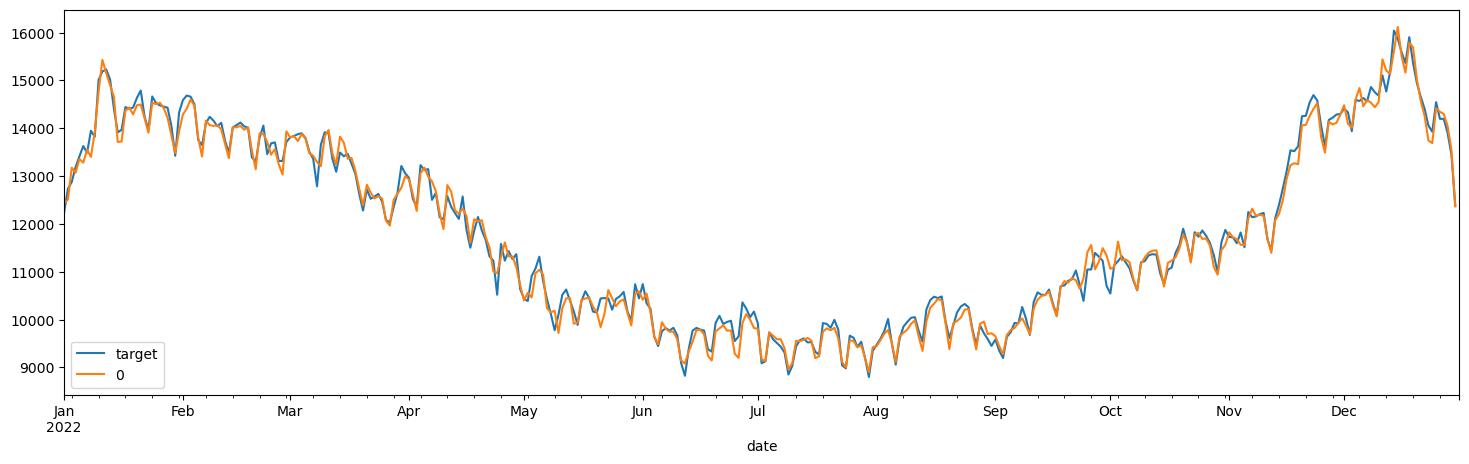

In [17]:
# Рисуем графическое представление предсказания на 2022 год

y_true_copy = pd.DataFrame(target_valid).reset_index(drop=True)
y_true_copy['day'] = y_true_copy.index // 24
y_true_grouped = y_true_copy.groupby(by='day').sum()   
y_true_grouped
y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
y_pred_copy['day'] = y_pred_copy.index // 24
y_pred_grouped = y_pred_copy.groupby(by='day').sum()

#pd.DataFrame(date_valid)
tmpdf = pd.DataFrame(train_ds.loc[features_valid.index,:]['date']).groupby(by='date').count().reset_index().join(y_true_grouped)
tmpdf.plot(x='date', y='target', figsize=(18,5))
ax=plt.gca()
tmpdf = pd.DataFrame(train_ds.loc[features_valid.index,:]['date']).groupby(by='date').count().reset_index().join(y_pred_grouped)
tmpdf.plot(ax=ax, x='date', y=0)

In [18]:
# Предсказываем отдельно по четырем кварталам 2022 года

for i, quarter in enumerate(quarters):
    mae = mae_day(quarter['target'], lgbm_model.predict(quarter['features']))
    print(f'{i+1} квартал mae = {mae}')

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
1 квартал mae = 141.30067122734303
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
2 квартал mae = 153.40411329533413
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
3 квартал mae = 116.37352243983574
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
4 квартал mae = 151.83591530675133


Как видно по предсказаниям, в задаче наблюдается значительная сезонность: предсказания на первый квартал 2022 года получились хуже, чем на прочие периоды. Какой сюрприз. В целом, из графического представления видно, что предказание в целом адекватно описывает динамику целевого признака.

In [19]:
# Предсказываем той же моделью (19-21) тренировочный кусок 2023 (первый квартал)
mae = mae_day(target_2023, lgbm_model.predict(features_2023))
print(f'mae = {mae}')

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
mae = 166.31263542767113


## XGBoost

In [20]:
#features_train, target_train
#features_valid, target_valid

In [21]:
pip install hyperopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.2 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 10.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [24]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [25]:
xgb_model = XGBRegressor(
    max_depth=7,
    n_estimators=195,
    learning_rate=0.1,
    tree_method='exact',
    objective='reg:squarederror',
    eval_metric='rmse',
    gamma=2,
    colsample_bytree=1,
    random_state=random_state
)

xgb_model.fit(features_train, target_train)

'''
params_xgb = {
    'max_depth': range(1, 11, 1),
    'n_estimators': range(10, 201, 5),
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5],
    'tree_method': ['approx', 'auto', 'exact', 'hist'],
    'colsample_bytree': [0.5, 1],
    'gamma': range(0, 10, 1),
    
}

grid_search_xbg = RandomizedSearchCV(
    xgb_model,
    param_distributions=params_xgb,
    n_jobs=-1,
    random_state=random_state,
    scoring='neg_mean_absolute_error'
)

grid_search_xbg.fit(features_train, target_train)
'''

"\nparams_xgb = {\n    'max_depth': range(1, 11, 1),\n    'n_estimators': range(10, 201, 5),\n    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5],\n    'tree_method': ['approx', 'auto', 'exact', 'hist'],\n    'colsample_bytree': [0.5, 1],\n    'gamma': range(0, 10, 1),\n    \n}\n\ngrid_search_xbg = RandomizedSearchCV(\n    xgb_model,\n    param_distributions=params_xgb,\n    n_jobs=-1,\n    random_state=random_state,\n    scoring='neg_mean_absolute_error'\n)\n\ngrid_search_xbg.fit(features_train, target_train)\n"

params_xgb = {
    'max_depth': range(1, 10, 1),
    'n_estimators': range(100, 201, 5),
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1, 2],
    'tree_method': ['approx', 'auto', 'exact', 'hist'],
}

In [ ]:
'''predictions_xgb = grid_search_xbg.predict(features_valid)
print(f'mae for days - {mae_day(target_valid, predictions_xgb)}')
print(f'mae for hours - {mean_absolute_error(target_valid, predictions_xgb)}')'''

predictions_xgb = xgb_model.predict(features_valid)
print(f'mae for days - {mae_day(target_valid, predictions_xgb)}')
print(f'mae for hours - {mean_absolute_error(target_valid, predictions_xgb)}')

<Axes: xlabel='date'>

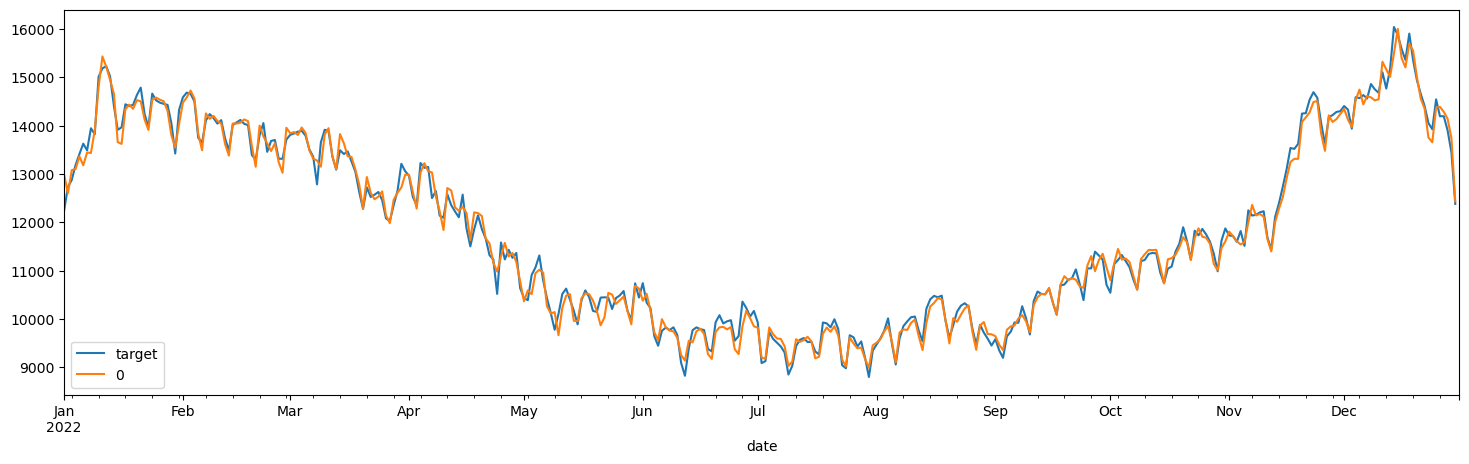

In [27]:
# Рисуем графическое представление предсказания на 2022 год

y_true_copy = pd.DataFrame(target_valid).reset_index(drop=True)
y_true_copy['day'] = y_true_copy.index // 24
y_true_grouped = y_true_copy.groupby(by='day').sum()   
y_true_grouped
y_pred_copy = pd.DataFrame(predictions_xgb).reset_index(drop=True)
y_pred_copy['day'] = y_pred_copy.index // 24
y_pred_grouped = y_pred_copy.groupby(by='day').sum()

#pd.DataFrame(date_valid)
tmpdf = pd.DataFrame(train_ds.loc[features_valid.index,:]['date']).groupby(by='date').count().reset_index().join(y_true_grouped)
tmpdf.plot(x='date', y='target', figsize=(18,5))
ax=plt.gca()
tmpdf = pd.DataFrame(train_ds.loc[features_valid.index,:]['date']).groupby(by='date').count().reset_index().join(y_pred_grouped)
tmpdf.plot(ax=ax, x='date', y=0)

In [28]:
for i, quarter in enumerate(quarters):
    mae = mae_day(quarter['target'], xgb_model.predict(quarter['features']))
    print(f'{i+1} квартал mae = {mae}')

1 квартал mae = 143.6888874131944
2 квартал mae = 155.87216878434066
3 квартал mae = 116.37706007982347
4 квартал mae = 146.90421705163052


In [29]:
# Предсказываем той же моделью (19-21) тренировочный кусок 2023 (первый квартал)
mae = mae_day(target_2023, xgb_model.predict(features_2023))
print(f'mae = {mae}')

mae = 173.72399131944445


#### 2.3 Процедурный отбор признаков
Для каждого признака проверим метрику без него и сравним с базовой метрикой, полученной со всеми признаками. Данная процедура позволит улучшить результаты за счет исключения признаков. Здесь обучение проходит на данных за 2019-2022 годы с валидацией на первом квартале 2023.

In [30]:
# Учим модель на 19-22 годах и предсказываем на тренировочный кусок 2023 (первый квартал)
# Это предсказание считаем основной валидационной базой для подбора признаков

lgbm_model_2022 = lgb.LGBMRegressor(**params)
lgbm_model_2022.fit(features_2022, target_2022)
mae = mae_day(target_2023, lgbm_model_2022.predict(features_2023))
print(f'mae = {mae}')
mae_base = mae

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 27
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
mae = 156.40736184618393


In [31]:
# Процедурный отбор признаков
# перебираем признаки, пробуем отбросить каждый и предсказать без него

feature_cols_no_date = feature_cols.copy()
feature_cols_no_date.remove('date')
feature_drop_list = []
for feature_name in feature_cols_no_date:
    tmp_train, tmp_valid = features_2022.copy(), features_2023.copy()
    tmp_train = tmp_train.drop(feature_name, axis=1)
    tmp_valid = tmp_valid.drop(feature_name, axis=1)
    lgbm_model_feature_drop = lgb.LGBMRegressor(**params)
    lgbm_model_feature_drop.fit(tmp_train, target_2022)
    mae = mae_day(target_2023, lgbm_model_feature_drop.predict(tmp_valid))
    feature_drop_list.append([feature_name, mae])
    print(f'dropped {feature_name} ----------> mae = {mae}')

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1506
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped time ----------> mae = 191.1443441668821
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1475
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped temp_pred ----------> mae = 184.58031077624946
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1525
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped year ----------> mae = 158.9690480770362
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1517
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped month ----------> mae = 174.84986352100438
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1523
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped day_of_week ----------> mae = 170.6993078080812
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1498
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped day ----------> mae = 173.783998518947
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped holidays ----------> mae = 165.82166535940033
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped preholidays ----------> mae = 158.03566650539915
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped temp_last_day ----------> mae = 157.34059155428736
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped target_lag_24 ----------> mae = 214.80579716200452
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped target_lag_72 ----------> mae = 160.48064756470902
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped target_lag_336 ----------> mae = 155.25036032369024
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1490
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped VVP ----------> mae = 154.72487643812616
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped cloudy ----------> mae = 156.36115997110025
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped rainy ----------> mae = 158.63439270109467
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped windy ----------> mae = 160.02342167185543
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped clear ----------> mae = 161.35418621895994
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped rain_probability ----------> mae = 159.24593763204325
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped has_rain_probability ----------> mae = 156.0276156656591
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1454
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped P ----------> mae = 159.76234179749153
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1455
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped U ----------> mae = 157.68277497549923
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total

/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped WW ----------> mae = 157.9487149343705
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1481
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped Td ----------> mae = 162.5098738235437
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped N ----------> mae = 162.54442906346213
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped S ----------> mae = 157.82131333807428
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped W ----------> mae = 157.89866931063455
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 34952, number of used features: 26
[LightGBM] [Info] Start training from score 469.440491


/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
dropped E ----------> mae = 159.34936179972908


In [32]:
# Процедурный отбор признаков
# Таблица названий признаков с изменениями метрики на валидации (первый квартал 2023) при отключении каждого
# В качестве дополнительного контроля при отключении признаков будем смотреть на изменении метрики за весь 2022 при обучении на 19-21
# С учетом дополнительного контроля по 2022 данный набор признаков считам финальным

feature_drop_list_df = pd.DataFrame( feature_drop_list, columns=['feature_name','mae_improvement']).sort_values(by='mae_improvement')
feature_drop_list_df['mae_improvement'] = mae_base - feature_drop_list_df['mae_improvement']
feature_drop_list_df.head()

,feature_name,mae_improvement
12,VVP,1.682485
11,target_lag_336,1.157002
18,has_rain_probability,0.379746
13,cloudy,0.046202
8,temp_last_day,-0.933230


Данная процедура позволила исключить ряд признаков и оставить оптимальный набор. Отметим, что при исключении решение принималось по результатам на двух вариантах тренировочного и валидационного датасетов: с разбиением по началу 2022 года и по началу 2023 года.

#### 2.4 График важности признаков
Визуализируем значение feature_importances_ модели

<Axes: ylabel='0'>

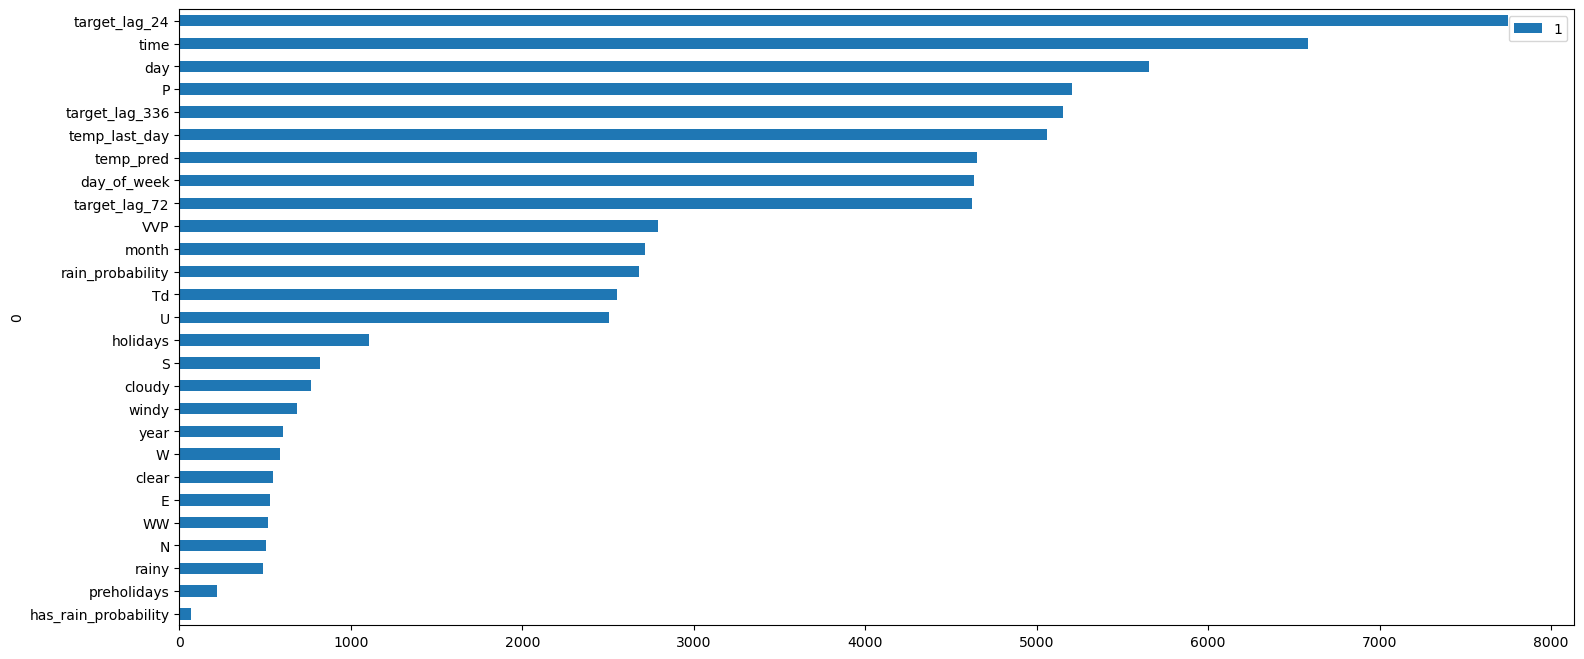

In [33]:
# График важности признаков

tmp_feature_cols = feature_cols.copy()
tmp_feature_cols.remove('date')
feature_importances = pd.DataFrame([tmp_feature_cols, lgbm_model.feature_importances_]).T.sort_values(by = 1)
feature_importances.plot(kind='barh', x=0, y=1, figsize=(18, 8))

### 4 Проверка метрик на тестовом датасете

In [34]:
# Проверка метрики лучшей модели на тестовом датасете
# Здесь обучаем на всем тренировочном датасете
params = {'num_leaves':15, 'learning_rate':0.02, 'feature_fraction':1, 'num_iterations':10000, 'random_state':random_state, 'objective':'regression_l1', 'n_jobs':-1}

lgbm_model_all_train = lgb.LGBMRegressor(**params)
lgbm_model_all_train.fit(features_all_train, target_all_train)

mae_train, mape_train, r2_train = metrics_day(target_all_train, lgbm_model_all_train.predict(features_all_train))
mae_open_test, mape_open_test, r2_open_test = metrics_day(target_open_test, lgbm_model_all_train.predict(features_open_test))

pd.DataFrame([['тренировочная', mae_train, mape_train, r2_train], ['тестовая', mae_open_test, mape_open_test, r2_open_test]], 
             columns=('Выборка', 'MAE', 'MAPE', 'R2'))

/home/user/anaconda3/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 37108, number of used features: 27
[LightGBM] [Info] Start training from score 473.058990
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


,Выборка,MAE,MAPE,R2
0,тренировочная,56.742334,0.005155,0.997388
1,тестовая,108.990518,0.010707,0.978252


### XGBoost test

In [35]:
# Проверка метрики лучшей модели на тестовом датасете
# Здесь обучаем на всем тренировочном датасете
xgb_model_all_train = xgb_model.fit(features_all_train, target_all_train)

mae_train, mape_train, r2_train = metrics_day(target_all_train, xgb_model_all_train.predict(features_all_train))
mae_open_test, mape_open_test, r2_open_test = metrics_day(target_open_test, xgb_model_all_train.predict(features_open_test))

pd.DataFrame([['тренировочная', mae_train, mape_train, r2_train], ['тестовая', mae_open_test, mape_open_test, r2_open_test]], 
             columns=('Выборка', 'MAE', 'MAPE', 'R2'))

,Выборка,MAE,MAPE,R2
0,тренировочная,50.263257,0.004510,0.998719
1,тестовая,112.810655,0.011032,0.977044


In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit

In [74]:
catboost_model = CatBoostRegressor(
    iterations=10000,
    learning_rate=0.015,
    depth=6,
    subsample=0.65,
    colsample_bylevel=0.95,
    min_data_in_leaf=51,
    l2_leaf_reg=9
)

catboost_model.fit(features_train, target_train)
'''
params_catboost = {
    'iterations': [10000],
    'learning_rate': [0.001, 0.005, 0.01, 0.015, 0.02, 0.03, 0.05, 0.1],
    'depth': range(1, 10, 1),
    'subsample': [x / 100.0 for x in range(5, 100, 10)],
    'colsample_bylevel': [x / 100.0 for x in range(5, 100, 10)],
    'min_data_in_leaf': range(1, 100, 10),
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    #'min_child_samples': [1, 4, 8, 16, 32]
}

grid_search_catboost = RandomizedSearchCV(
    catboost_model,
    cv = TimeSeriesSplit(n_splits=4),
    param_distributions=params_catboost,
    n_jobs=-1,
    random_state=random_state,
    scoring='neg_mean_absolute_error'
)

grid_search_catboost.fit(features_train, target_train)'''

0:	learn: 99.5376515	total: 1.95ms	remaining: 19.5s
1:	learn: 98.2259246	total: 4.24ms	remaining: 21.2s
2:	learn: 96.9031909	total: 6.42ms	remaining: 21.4s
3:	learn: 95.5849338	total: 8.36ms	remaining: 20.9s
4:	learn: 94.3210274	total: 10.5ms	remaining: 21s
5:	learn: 93.1162958	total: 12.5ms	remaining: 20.8s
6:	learn: 91.8816055	total: 14.4ms	remaining: 20.6s
7:	learn: 90.6538187	total: 16.4ms	remaining: 20.4s
8:	learn: 89.4586474	total: 18.3ms	remaining: 20.3s
9:	learn: 88.2948808	total: 20.2ms	remaining: 20.2s
10:	learn: 87.1628998	total: 22.1ms	remaining: 20.1s
11:	learn: 86.0497316	total: 23.9ms	remaining: 19.9s
12:	learn: 84.9096303	total: 25.8ms	remaining: 19.9s
13:	learn: 83.8196317	total: 27.6ms	remaining: 19.7s
14:	learn: 82.7272435	total: 29.3ms	remaining: 19.5s
15:	learn: 81.6586499	total: 31.1ms	remaining: 19.4s
16:	learn: 80.5993651	total: 33.4ms	remaining: 19.6s
17:	learn: 79.5678055	total: 35.3ms	remaining: 19.6s
18:	learn: 78.5819000	total: 37.1ms	remaining: 19.5s
19:	l

"\nparams_catboost = {\n    'iterations': [10000],\n    'learning_rate': [0.001, 0.005, 0.01, 0.015, 0.02, 0.03, 0.05, 0.1],\n    'depth': range(1, 10, 1),\n    'subsample': [x / 100.0 for x in range(5, 100, 10)],\n    'colsample_bylevel': [x / 100.0 for x in range(5, 100, 10)],\n    'min_data_in_leaf': range(1, 100, 10),\n    'l2_leaf_reg': [1, 3, 5, 7, 9],\n    #'min_child_samples': [1, 4, 8, 16, 32]\n}\n\ngrid_search_catboost = RandomizedSearchCV(\n    catboost_model,\n    cv = TimeSeriesSplit(n_splits=4),\n    param_distributions=params_catboost,\n    n_jobs=-1,\n    random_state=random_state,\n    scoring='neg_mean_absolute_error'\n)\n\ngrid_search_catboost.fit(features_train, target_train)"

In [75]:
grid_search_catboost.best_params_

{'subsample': 0.65,
 'min_data_in_leaf': 51,
 'learning_rate': 0.015,
 'l2_leaf_reg': 9,
 'iterations': 10000,
 'depth': 6,
 'colsample_bylevel': 0.95}

In [76]:
abs(grid_search_catboost.best_score_)

11.318673558184727

In [77]:
predictions_catboost = grid_search_catboost.predict(features_valid)
print(f'mae for days - {mae_day(target_valid, predictions_catboost)}')
print(f'mae for hours - {mean_absolute_error(target_valid, predictions_catboost)}')


predictions_catboost = catboost_model.predict(features_valid)
print(f'mae for days - {mae_day(target_valid, predictions_catboost)}')
print(f'mae for hours - {mean_absolute_error(target_valid, predictions_catboost)}')

mae for days - 146.9640368075975
mae for hours - 8.028578845538004
mae for days - 146.9640368075975
mae for hours - 8.028578845538004
